In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [55]:
from matplotlib import pyplot as plt
%matplotlib inline

In [68]:
# https://www.tensorflow.org/tutorials/keras/basic_regression

### Dataset Prep

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\wsutt\\.keras\\datasets\\auto-mpg.data'

In [3]:
column_names = ['MPG','Cyliners','Displacement','Horsepower'
                ,'Weight','Acceleration', 'Model_Year', 'Origin']

In [4]:
raw_dataset = pd.read_csv (dataset_path
                          ,names=column_names
                          ,na_values='?'
                          ,comment='\t'
                          ,sep=' '
                          ,skipinitialspace=True
                          )

In [5]:
dataset = raw_dataset.copy()

In [6]:
dataset.tail()

,MPG,Cyliners,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
len(dataset)

398

In [9]:
dataset.isna().sum()

MPG             0
Cyliners        0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model_Year      0
Origin          0
dtype: int64

In [10]:
dataset = dataset.dropna()

In [11]:
len(dataset)

392

In [12]:
origin = dataset.pop('Origin')

In [15]:
dataset.columns

Index(['MPG', 'Cyliners', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model_Year'],
      dtype='object')

##### Categorical + split target + split train/test

In [16]:
code_name = ['USA','Europe','Japan']
for _o in range(3):
    dataset[code_name[_o]] = (origin == (_o+1))*1.0

In [17]:
dataset.columns

Index(['MPG', 'Cyliners', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model_Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [18]:
dataset.tail()

,MPG,Cyliners,Displacement,Horsepower,Weight,Acceleration,Model_Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [19]:
RANDOM_STATE = 0
train = dataset.sample(frac=0.8, random_state=RANDOM_STATE)
test = dataset.drop(train.index)

In [20]:
len(train), len(test)

(314, 78)

In [21]:
train_y = train.pop('MPG')
test_y = test.pop('MPG')

##### exploratory

In [23]:
train_stats = train.describe()
train_stats


,Cyliners,Displacement,Horsepower,Weight,Acceleration,Model_Year,USA,Europe,Japan
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.624204,0.178344,0.197452
std,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.485101,0.383413,0.398712
min,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,1.000000,0.000000,0.000000
max,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [26]:
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cyliners,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model_Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


##### Normalization

In [29]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
    
norm_train = norm(train)
norm_test = norm(test)

In [49]:
col0 = norm_train[norm_train.columns[0]]
type(col0)

pandas.core.series.Series

In [52]:
mean_col0 = col0.sum() / col0.count()
mean_col0

1.824442932186563e-16

In [36]:
series_x = norm_train.T[:1]
series_x

,146,282,69,378,331,257,310,328,125,108,...,171,70,307,49,209,281,229,150,145,182
Cyliners,-0.869348,-0.869348,1.483887,-0.869348,-0.869348,0.30727,-0.869348,-0.869348,0.30727,-0.869348,...,-0.869348,1.483887,0.30727,-0.869348,-0.869348,0.30727,1.483887,-0.869348,-0.869348,-0.869348


In [54]:
norm_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Cyliners,314.0,1.824443e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,8.627211e-17,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-9.900078e-18,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-8.485781e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,-5.148041e-16,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model_Year,314.0,9.772791e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,7.920062e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,1.980016e-17,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,5.374328e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


In [58]:
norm_train.columns

Index(['Cyliners', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model_Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

(array([ 2., 13., 14., 17., 30., 16., 15., 15., 19., 15., 13., 16.,  7.,
        11.,  9., 15., 11., 10.,  7.,  8.,  5.,  8.,  9., 11.,  5.,  5.,
         2.,  1.,  4.,  1.]),
 array([-1.58935161, -1.45145985, -1.31356808, -1.17567632, -1.03778455,
        -0.89989279, -0.76200102, -0.62410926, -0.48621749, -0.34832573,
        -0.21043396, -0.0725422 ,  0.06534957,  0.20324133,  0.3411331 ,
         0.47902486,  0.61691663,  0.75480839,  0.89270016,  1.03059192,
         1.16848368,  1.30637545,  1.44426721,  1.58215898,  1.72005074,
         1.85794251,  1.99583427,  2.13372604,  2.2716178 ,  2.40950957,
         2.54740133]),
 <a list of 30 Patch objects>)

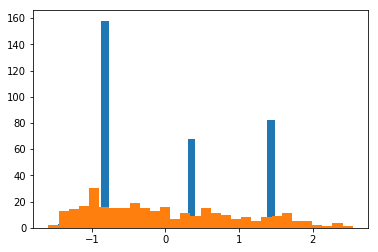

In [60]:
plt.hist(norm_train['Cyliners'], bins=30)
plt.hist(norm_train['Weight'], bins=30)

### Build Model

In [64]:
def buildModel(input_shape, N=64, learning_rate=0.001):
    
    if input_shape is None:
        return None
    
    model = keras.Sequential([
    
                    keras.layers.Dense (
                                  units=N
                                 ,activation=tf.nn.relu
                                 ,input_shape=input_shape
                                 )
                    ,keras.layers.Dense (
                                  units=N
                                 ,activation=tf.nn.relu
                                 )
                    ,keras.layers.Dense(1)
                    ])
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    
    model.compile(loss='mean_squared_error'
                  ,optimizer=optimizer
                  ,metrics=['mean_absolute_error'
                             ,'mean_squared_error'
                            ]
                 )
    
    return model

In [65]:
input_shape = [len(train.keys())]
model = buildModel(input_shape=input_shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


##### Poke the model

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [67]:
example_batch = norm_train[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.2402215 ],
       [-0.23552099],
       [-0.24152042],
       [-0.16613275],
       [-0.0508136 ],
       [-0.14267273],
       [-0.07259547],
       [-0.34354645],
       [-0.23229957],
       [-0.04320659]], dtype=float32)

##### Train model

In [70]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500

history = model.fit(
             x=norm_train
            ,y=train_y
            ,epochs=EPOCHS
            ,validation_split=0.2
            ,verbose=0
            ,callbacks=[PrintDot()]
            )


Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

##### Analyze Model's History

In [71]:
type(history)

tensorflow.python.keras.callbacks.History

In [77]:
hist = pd.DataFrame(history.history)

In [79]:
len(hist)

500

In [80]:
hist.columns

Index(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_mean_squared_error'],
      dtype='object')

In [81]:
hist['epoch'] = history.epoch

In [82]:
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
495,3.796245,1.289797,3.796244,8.070607,2.209781,8.070606,495
496,3.956808,1.315557,3.956808,7.931583,2.199826,7.931582,496
497,3.651968,1.250812,3.651968,9.021258,2.334018,9.021257,497
498,3.973207,1.267104,3.973207,8.234116,2.200907,8.234116,498
499,3.800376,1.269928,3.800376,8.525912,2.259838,8.525912,499


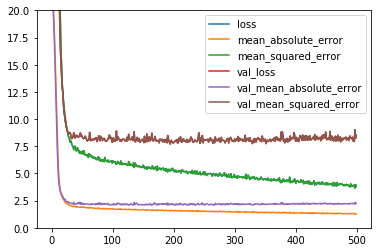

In [107]:
y_data = list(hist.columns)
y_data.pop(y_data.index('epoch'))

for y_label in y_data:
    plt.plot(hist['epoch'], hist[y_label], label=y_label)
    
plt.ylim([0,20])
plt.legend()
plt.show()

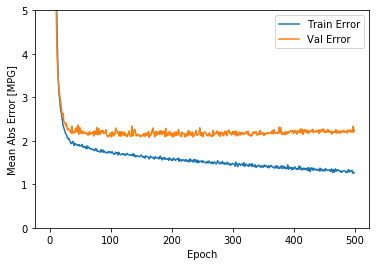

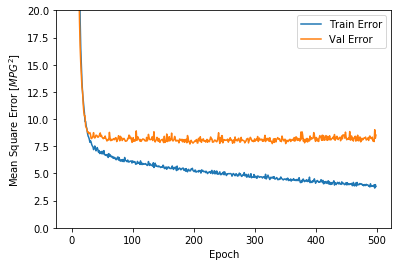

In [108]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

### New Run

In [109]:
input_shape = [len(train.keys())]

model2 = buildModel(input_shape=input_shape)

In [110]:
EPOCHS = 1500

history2 = model2.fit(
             x=norm_train
            ,y=train_y
            ,epochs=EPOCHS
            ,validation_split=0.2
            ,verbose=0
            ,callbacks=[PrintDot()]
            )



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

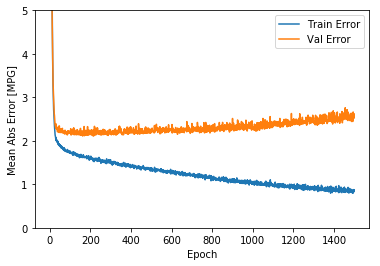

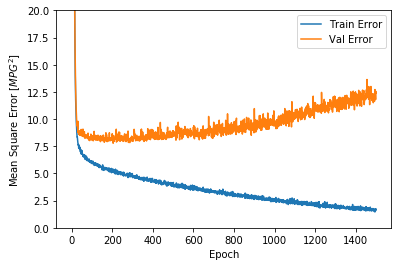

In [111]:
plot_history(history)

### Evaluate

In [113]:
import random

In [128]:
N=1
i = random.sample(range(len(test)), N)
i=i[0]
x_predict = norm_test[i:i+1]
y_predict = model.predict(x_predict,)
y_truth = list(test_y[i:i+1])
print(i, y_predict, y_truth)

55 [[18.358475]] [18.5]


In [133]:
model.evaluate(x=norm_test,y=test_y,verbose=0)

[5.942751542115823, 1.8425388, 5.9427514]

In [134]:
model2.evaluate(x=norm_test,y=test_y,verbose=0)

[8.10288233634753, 2.2158294, 8.102882]

In [137]:
predict_model_1 = model.predict(x=norm_test)
predict_model_2 = model2.predict(x=norm_test) 

In [140]:
pred_1 = [x[0] for x in predict_model_1]
pred_2 = [x[0] for x in predict_model_2]

In [150]:
def plotPredVsActual(y_hat):
    plt.scatter(list(test_y), y_hat)
    plt.xlabel('truth')
    plt.ylabel('predicted')
    high = plt.xlim()[1]
    plt.xlim([0, high])
    plt.ylim([0, high])
    plt.plot([-100, 100], [-100, 100])

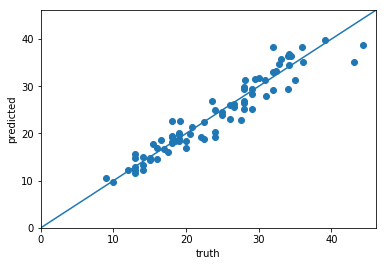

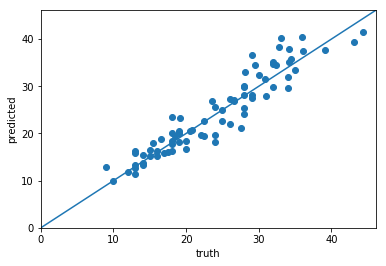

In [151]:
plotPredVsActual(pred_1)
plt.show()
plotPredVsActual(pred_2)
plt.show()

In [131]:
help(keras.Sequential.evaluate)

Help on function evaluate in module tensorflow.python.keras.engine.training:

evaluate(self, x=None, y=None, batch_size=None, verbose=1, sample_weight=None, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    Returns the loss value & metrics values for the model in test mode.
    
    Computation is done in batches.
    
    Arguments:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
            (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
            (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
            if the model has named inputs.
          - A `tf.data` dataset or a dataset iterator.
          - A generator or `keras.utils.Sequence` instance.
        y: Target data. Like the input data `x`,
          it could be either Numpy array(s) or TensorFlow tensor(s).
          It should be consiste

In [69]:
help(keras.Sequential)

Help on class Sequential in module tensorflow.python.keras.engine.sequential:

class Sequential(tensorflow.python.keras.engine.training.Model)
 |  Sequential(layers=None, name=None)
 |  
 |  Linear stack of layers.
 |  
 |  Arguments:
 |      layers: list of layers to add to the model.
 |  
 |  Example:
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = Sequential()
 |  model.add(Dense(32, input_shape=(500,)))
 |  # Afterwards, we do automatic shape inference:
 |  model.add(Dense(32))
 |  
 |  # This is identical to the following:
 |  model = Sequential()
 |  model.add(Dense(32, input_dim=500))
 |  
 |  # And to the following:
 |  model = Sequential()
 |  model.add(Dense(32, batch_input_shape=(None, 500)))
 |  
 |  # Note that you can also omit the `input_shape` argument:
 |  # In that case the model gets built the first time you call `fit` (or other
 |  # training and evaluation methods).
 |  model = Sequential()
 |  model.add(Dense